In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("PromptCloudHQ/amazon-reviews-unlocked-mobile-phones")

print("Path to dataset files:", path)

100%|██████████| 32.6M/32.6M [00:00<00:00, 56.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones/versions/1


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from tensorflow.keras.preprocessing import sequence # Use tensorflow.keras instead of keras
from tensorflow.keras.utils import to_categorical # Import to_categorical for one-hot encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Lambda
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import defaultdict
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Embedding

In [ ]:
path_to_csv = path + "/Amazon_Unlocked_Mobile.csv"  # Adjust filename if necessary
df = pd.read_csv(path_to_csv)


In [ ]:
import os

# List the contents of the directory where the dataset was downloaded
print(os.listdir(path))

['Amazon_Unlocked_Mobile.csv']


In [ ]:
df

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0
...,...,...,...,...,...,...
413835,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,another great deal great price,0.0
413836,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,Ok,0.0
413837,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,Passes every drop test onto porcelain tile!,0.0
413838,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,I returned it because it did not meet my needs...,0.0


In [ ]:
print("Summary statistics of numerical features : \n", df.describe())

print("\nTotal number of reviews: ",len(df))
print("\nTotal number of brands: ", len(list(set(df['Brand Name']))))
print("\nTotal number of unique products: ", len(list(set(df['Product Name']))))

print("\nPercentage of reviews with neutral sentiment : {:.2f}%"\
      .format(df[df['Rating']==3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%"\
      .format(df[df['Rating']>3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with negative sentiment : {:.2f}%"\
      .format(df[df['Rating']<3]["Reviews"].count()/len(df)*100))

Summary statistics of numerical features : 
                Price         Rating   Review Votes
count  407907.000000  413840.000000  401544.000000
mean      226.867155       3.819578       1.507237
std       273.006259       1.548216       9.163853
min         1.730000       1.000000       0.000000
25%        79.990000       3.000000       0.000000
50%       144.710000       5.000000       0.000000
75%       269.990000       5.000000       1.000000
max      2598.000000       5.000000     645.000000

Total number of reviews:  413840

Total number of brands:  385

Total number of unique products:  4410

Percentage of reviews with neutral sentiment : 7.68%

Percentage of reviews with positive sentiment : 68.85%

Percentage of reviews with negative sentiment : 23.45%


Text(0, 0.5, 'Count')

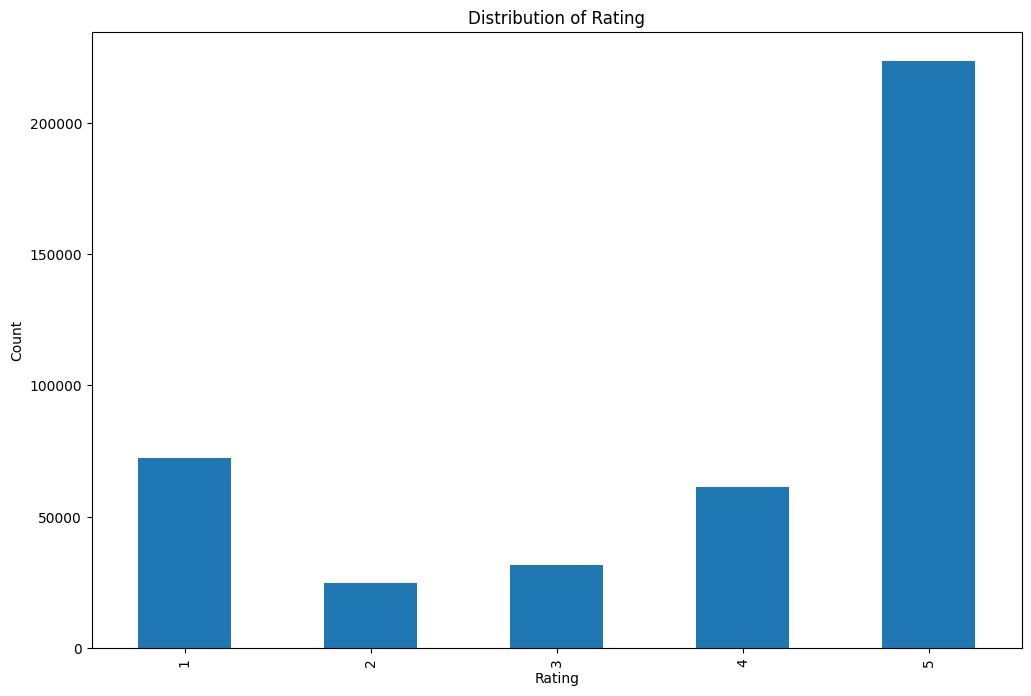

In [ ]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0.5, 1.0, 'Number of Reviews for Top 20 Brands')

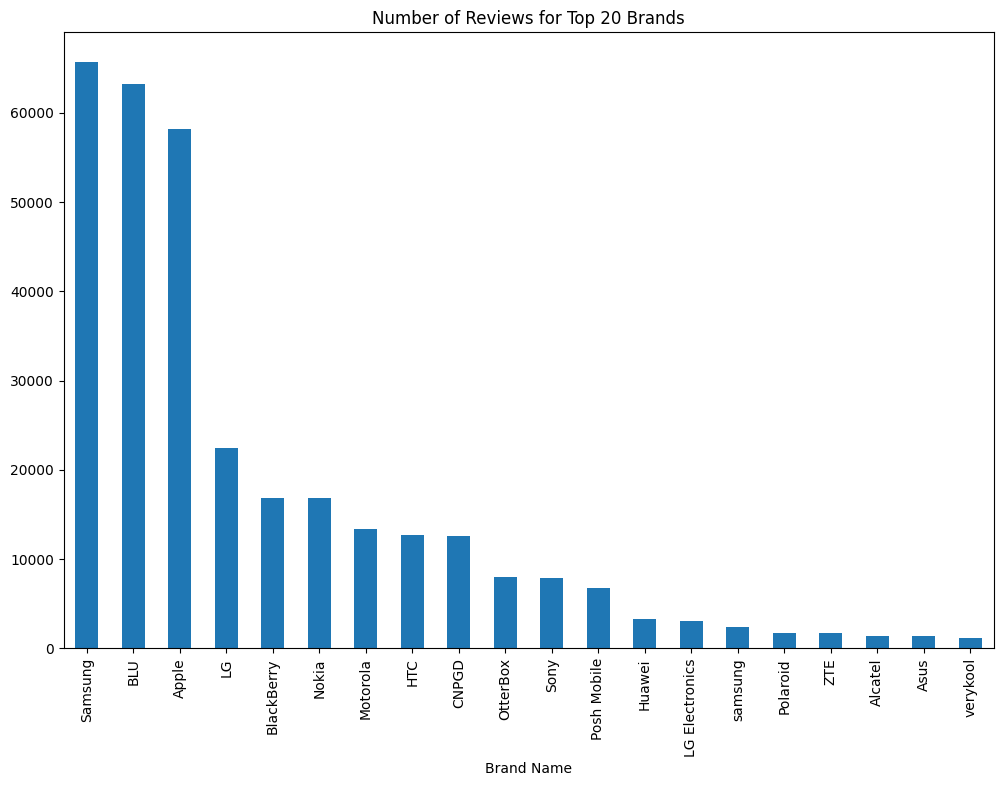

In [ ]:
# Plot number of reviews for top 20 brands
brands = df["Brand Name"].value_counts()
# brands.count()
plt.figure(figsize=(12,8))
brands[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Brands")

In [ ]:
df = df.sample(frac=0.1, random_state=0) #uncomment to use full set of data

# Drop missing values
df.dropna(inplace=True)

# Remove any 'neutral' ratings equal to 3
df = df[df['Rating'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['Rating'] > 3, 1, 0)
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Sentiment
134801,BLU Studio 5.0 C HD - Unlocked Cell Phones - R...,BLU,2000.00,5,"For the price I paid for this devices, its fan...",0.0,1
123493,Blu LIFE 8 Unlocked (Pink),BLU,199.98,5,love love love it....good buy...recommend to a...,0.0,1
335592,Samsung Galaxy S Duos II S7582 DUAL SIM Factor...,Samsung,299.99,4,Good,0.0,1
246353,"Motorola Droid 2 A955 Verizon Phone 5MP Cam, W...",Motorola,82.00,1,Not good. Returned first phone and they sent m...,0.0,0
273324,Nokia Lumia 920 32GB Unlocked GSM 4G LTE Windo...,Nokia,149.35,4,Met expectations! I'm very satisfied!Even arri...,1.0,1


In [ ]:
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], df['Sentiment'], \
                                                    test_size=0.1, random_state=0)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 27799 training examples and 3089 validation examples. 

Show a review in the training set : 
 good product and fast shipping. thank you.


**Text Preprocessing**

The following text preprocessing are implemented to convert raw reviews to cleaned review, so that it will be easier for us to do feature extraction in the next step.

remove html tags using BeautifulSoup

remove non-character such as digits and symbols

convert to lower case

remove stop words such as "the" and "and" if needed

convert to root words by stemming if needed
**bold text**

In [ ]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case

    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english')
        words = [stemmer.stem(w) for w in words]

    if split_text==True:  # split text
        return (words)

    return( " ".join(words))

In [ ]:
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])

for d in X_test:
    X_test_cleaned.append(cleanText(d))

<ipython-input-16-adb71888fad2>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
<ipython-input-16-adb71888fad2>:6: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html


Show a cleaned review in the training set : 
 good product and fast shipping thank you


In [ ]:
countVect = CountVectorizer()
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(countVect.get_feature_names_out())) #6378
print("Show some feature names : \n", countVect.get_feature_names_out()[::1000])


# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)

Number of features : 19607 

Show some feature names : 
 ['aa' 'areable' 'boot' 'clean' 'crushing' 'distortions' 'excatly' 'frills'
 'heart' 'inverter' 'lolit' 'movie' 'over' 'predictable' 'reconnecting'
 'scaling' 'soldto' 'tapped' 'ubuntu' 'wedges']


MultinomialNB()

In [ ]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [ ]:
predictions = mnb.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9184

AUC score : 0.8790

Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.80      0.83       778
           1       0.93      0.96      0.95      2311

    accuracy                           0.92      3089
   macro avg       0.90      0.88      0.89      3089
weighted avg       0.92      0.92      0.92      3089


Confusion Matrix : 
 [[ 622  156]
 [  96 2215]]


**TfidfVectorizer with Logistic Regression**

Some words might frequently appear but have little meaningful information about the sentiment of a particular review. Instead of using occurance counting, we can use tf-idf transform to scale down the impact of frequently appeared words in a given corpus.

In sklearn library, we can use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class.

In [ ]:
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names_out())) #1722
print("Show some feature names : \n", tfidf.get_feature_names_out()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 5987 

Show some feature names : 
 ['00' 'changing' 'fall' 'letting' 'primarily' 'stars']


LogisticRegression()

In [ ]:
feature_names = np.array(tfidf.get_feature_names_out())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['not' 'return' 'disappointed' 'horrible' 'waste' 'worst' 'poor' 'stopped'
 'slow' 'doesn']

Top 10 features with largest coefficients : 
['great' 'love' 'excellent' 'good' 'perfect' 'easy' 'best' 'amazing' 'far'
 'awesome']


In [ ]:
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9333

AUC score : 0.9026

Classification report : 
               precision    recall  f1-score   support

           0       0.89      0.84      0.86       778
           1       0.95      0.96      0.96      2311

    accuracy                           0.93      3089
   macro avg       0.92      0.90      0.91      3089
weighted avg       0.93      0.93      0.93      3089


Confusion Matrix : 
 [[ 654  124]
 [  82 2229]]


**Word2Vec**

Another common approach of word embedding is prediction based embedding, such as Word2Vec model. In gist, Word2Vec is a combination of two techniques: Continuous Bag of Words (CBoW) and skip-gram model. Both are shallow neural networks which learn weights for word vector representations.

In this part, we will train Word2Vec model to create our own word vector representations using gensim library. Then we fit the feature vectors of the reviews to Random Forest Classifier. Here's the workflow of this part.

Step 1 : Parse review text to sentences (Word2Vec model takes a list of sentences as inputs)

Step 2 : Create volcabulary list using Word2Vec model

Step 3 : Transform each review into numerical representation by computing average feature vectors of words therein

Step 4 : Fit the average feature vectors to Random Forest Classifier

In [ ]:
import nltk


nltk.download('punkt')

# Now load the tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Split review text into parsed sentences uisng NLTK's punkt tokenizer
# nltk.download()
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))
    return sentences


# Parse each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)

print('%d parsed sentence in the training set\n'  %len(sentences))
print('Show a parsed sentence in the training set : \n',  sentences[10])

27768 parsed sentence in the training set

Show a parsed sentence in the training set : 
 ['good', 'product', 'and', 'fast', 'shipping', 'thank', 'you']


In [ ]:

# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

num_features = 300  #embedding dimension
min_word_count = 10
num_workers = 4
context = 10
downsampling = 1e-3

print("Training Word2Vec model ...\n")
w2v = Word2Vec(sentences, workers=num_workers, vector_size=num_features, min_count = min_word_count,\
                 window = context, sample = downsampling)
w2v.init_sims(replace=True)
w2v.save("w2v_300features_10minwordcounts_10context") #save trained word2vec model

print("Number of words in the vocabulary list : %d \n" %len(w2v.wv.index_to_key)) #4016
print("Show first 10 words in the vocalbulary list  vocabulary list: \n", w2v.wv.index_to_key[0:10])

Training Word2Vec model ...



<ipython-input-34-e43aff036bf0>:12: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v.init_sims(replace=True)


Number of words in the vocabulary list : 4016 

Show first 10 words in the vocalbulary list  vocabulary list: 
 ['the', 'i', 'it', 'and', 'phone', 'a', 'to', 'is', 'this', 'for']


**Averaging Feature Vectors**

Now we have created a volcabulary list of words, with each word having a word representation (ie. feature vector of dim 300).

To find a numerical representation for a review, we run through each word in a review text. For words appear in the volcabulary list, we compute the average feature vectors of all those words. The average feature vector is the numerical represenation of the review.

In [ ]:
# Transfrom the training data into feature vectors

def makeFeatureVec(review, model, num_features):
    '''
    Transform a review to a feature vector by averaging feature vectors of words
    appeared in that review and in the volcabulary list created
    '''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index_to_key) #index2word is the volcabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model.wv[word])
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec



def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Get feature vectors for training set
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" %trainVector.shape)


# Get feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" %testVector.shape)


<ipython-input-16-adb71888fad2>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
<ipython-input-16-adb71888fad2>:6: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html


Training set : 27799 feature vectors with 300 dimensions
Validation set : 3089 feature vectors with 300 dimensions


In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)


Accuracy on validation set: 0.9291

AUC score : 0.8951

Classification report : 
               precision    recall  f1-score   support

           0       0.88      0.83      0.85       778
           1       0.94      0.96      0.95      2311

    accuracy                           0.93      3089
   macro avg       0.91      0.90      0.90      3089
weighted avg       0.93      0.93      0.93      3089


Confusion Matrix : 
 [[ 643  135]
 [  84 2227]]


**Simple LSTM**

We need to preprocess the text data to 2D tensor before we fit into a simple LSTM. First, we tokenize the corpus by only considering top words (top_words = 20000), and transform reviews to numerical sequences using the trained tokenizer. Next, we make sure that all numerical sequences have the same length (maxlen=100) for modeling, by truncating long reviews and pad shorter reviews with zero values.

To construct a simple LSTM, we use embedding class in Keras to construct the first layer. This embedding layer converts numerical sequence of words into a word embedding. We should note that the embedding class provides a convenient way to map discrete words into a continuous vector space, but it does not take the semantic similarity of the words into account. The next layer is the LSTM layer with 128 memory units. Finally, we use a dense output layer with a single neuron and a sigmoid activation function to make 0 or 1 predictions for the two classes (positive sentiment and negative sentiment). Since it is a binary classification problem, log loss is used as the loss function (binary_crossentropy in Keras). ADAM optimization algorithm is used.

Here's the workflow in this part.

Step 1 : Prepare X_train and X_test to 2D tensor
Step 2 : Train a simple LSTM (embeddign layer => LSTM layer => dense layer)
Step 3 : Compile and fit the model using log loss function and ADAM optimizer

In [ ]:
top_words = 20000
maxlen = 100
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = keras.utils.to_categorical(y_train, nb_classes)
y_test_seq = keras.utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/text.py:98: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


X_train shape: (27799, 100)
X_test shape: (3089, 100)
y_train shape: (27799, 2)
y_test shape: (3089, 2)


In [ ]:
model1 = Sequential()
model1.add(Embedding(top_words, 128))
model1.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(nb_classes))
model1.add(Activation('softmax'))
model1.summary()

# Compile LSTM
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)

# Model evluation
score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
869/869 ━━━━━━━━━━━━━━━━━━━━ 186s 208ms/step - accuracy: 0.8401 - loss: 0.3607
Epoch 2/3
869/869 ━━━━━━━━━━━━━━━━━━━━ 198s 204ms/step - accuracy: 0.9423 - loss: 0.1630
Epoch 3/3
869/869 ━━━━━━━━━━━━━━━━━━━━ 202s 204ms/step - accuracy: 0.9576 - loss: 0.1250
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9414 - loss: 0.1732
Test loss : 0.1645
Test accuracy : 0.9459


In [ ]:
model1.layers[0].get_weights()[0] # weight matrix of the embedding layer, word-by-dim matrix
print("Size of weight matrix in the embedding layer : ", \
      model1.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model1.layers[1].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model1.layers[2].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (20000, 128)
Size of weight matrix in the hidden layer :  (128, 512)
Size of weight matrix in the output layer :  (128, 2)


**LSTM with Word2Vec Embedding**

In the simple LSTM model constructed above, the embedding class in Keras comes in handy to converts numerical sequence of words into a word embedding, but it does not take the semantic similarity of the words into account. The model assigns random weights to the embedding layer and learn the embeddings by minimizing the global error of the network.

Instead of using random weights, we can use pretrained word embeddings to initialize the weight of an embedding layer. In this part, we use the Word2Vec embedding trained in Part 4 to intialize the weights of embedding layer in LSTM.

Step 1 : Load pretrained word embedding model
Step 2 : Construct embedding layer using embedding matrix as weights
Step 3 : Train a LSTM with Word2Vec embedding (embeddign layer => LSTM layer => dense layer)
Step 4 : Compile and fit the model using log loss function and ADAM optimizer

In [ ]:
w2v = Word2Vec.load("w2v_300features_10minwordcounts_10context")


# Get Word2Vec embedding matrix
embedding_matrix = w2v.wv.vectors  # embedding matrix, type = numpy.ndarray
print("Shape of embedding matrix : ", embedding_matrix.shape) #(4016, 300) = (volcabulary size, embedding dimension)
# w2v.wv.syn0[0] #feature vector of the first word in the volcabulary list

Shape of embedding matrix :  (4016, 300)


In [ ]:
top_words = embedding_matrix.shape[0] #4016
maxlen = 100
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = keras.utils.to_categorical(y_train, nb_classes)
y_test_seq = keras.utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/text.py:98: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


X_train shape: (27799, 100)
X_test shape: (3089, 100)
y_train shape: (27799, 2)
y_test shape: (3089, 2)


In [ ]:
embedding_layer = Embedding(embedding_matrix.shape[0], #4016
                            embedding_matrix.shape[1], #300
                            weights=[embedding_matrix])


# Construct LSTM with Word2Vec embedding
model2 = Sequential()
model2.add(embedding_layer)
model2.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))
model2.summary()

# Compile model
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)


# Model evaluation
score = model2.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │       1,204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,204,800 (4.60 MB)

 Trainable params: 1,204,800 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
869/869 ━━━━━━━━━━━━━━━━━━━━ 226s 256ms/step - accuracy: 0.8465 - loss: 0.3441
Epoch 2/3
869/869 ━━━━━━━━━━━━━━━━━━━━ 216s 248ms/step - accuracy: 0.9358 - loss: 0.1742
Epoch 3/3
869/869 ━━━━━━━━━━━━━━━━━━━━ 264s 251ms/step - accuracy: 0.9523 - loss: 0.1296
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9334 - loss: 0.1855
Test loss : 0.1668
Test accuracy : 0.9395


In [ ]:
print("Size of weight matrix in the embedding layer : ", \
      model2.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model2.layers[1].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model2.layers[2].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (4016, 300)
Size of weight matrix in the hidden layer :  (300, 512)
Size of weight matrix in the output layer :  (128, 2)


In [ ]:
# Custom input sentiment prediction
def predict_sentiment(custom_input, tokenizer, model2, max_sequence_length):
    # Preprocess the custom input
    custom_input_seq = tokenizer.texts_to_sequences([custom_input])
    custom_input_padded = sequence.pad_sequences(custom_input_seq, maxlen=max_sequence_length)

    # Predict sentiment
    prediction = model2.predict(custom_input_padded)
    sentiment = 'Positive' if prediction[0][1] >= 0.5 else 'Negative'
    print(f"Predicted Sentiment: {sentiment}")
    print(f"Prediction Confidence: {prediction[0][0]:.2f}")

# Example Usage:
custom_input = "This prdouct is broken"  # Example custom input
predict_sentiment(custom_input, tokenizer, model2, maxlen)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Sentiment: Negative
Prediction Confidence: 1.00
